# INFO8010: Project
Detailed description: see [README.md](README.md)

NB: references in this notebook point towards the README's references

## 0. Preamble

Importing torch and required libraries, plus miscellaneous definitions

### 0.1. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torchdata
import torchvision.transforms as imgtransforms

from typing import Tuple

from torchvision import models as imgmodels

from data import SpecDataset

### 0.2. Audio player

As this features does not work on VS Code, here is a work-around stolen from [here](https://github.com/microsoft/vscode-jupyter/issues/1012#issuecomment-785410064) to have a working audio player on VSC.

In [2]:
import ipywidgets as widgets

vsc_check = widgets.Checkbox(
    value=False,
    description="VS Code user ?",
    disabled=False,
    tooltip="Do you use VS Code to see this notebook ?",
    indent=False,
)

display(vsc_check)

Checkbox(value=False, description='VS Code user ?', indent=False)

In [3]:
import IPython.display as ipd
import json

def VSC_Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return ipd.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

def NonVSC_Audio(audio, sr):
    return ipd.Audio(audio, rate=sr)

audio_player = VSC_Audio if vsc_check.value else NonVSC_Audio

## 1. Data loading

First, define:
1. the transformer used to pre-process the data
1. the loader to be used to load the data for the GTZAN dataset (to start with, to be patched if not sufficient)

### 1.1. Transformer

**Reminder**: Mel spectrogram "algo"
1. Take a window of `win_length` samples of the input at current position
2. Compute fft with frequency spectrum is sepatated in `n_mels` evenly spaced frequencies, then apply mel scale on it (log-like), use `n_fft` samples for that computation
3. Append the computed column to the result
4. Move the window of `hop_length`
5. Restart in 1.

For an input of length `N`, this results in a matrix that has:
- `N / hop_length` columns
- `n_mels` rows

In our case, as input sequence are cropped at `sequence_duration` seconds, aim at:
- Width: `ceil(sequence_duration × sampling_rate / hop_length)` columns
- Height: `n_mels`

In [4]:
# Duration of the sequence to randomly crop out of the original sequence
sequence_duration = 20    # s

# parameters value taken from reference [1]
gtzan_sampling_rate = 22050 # Hz
sampling_rate = 12000      # 12 kHz

transform = imgtransforms.RandomApply([
    imgtransforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4, hue=0.1),
    imgtransforms.GaussianBlur(3, sigma=(0.1, 1)),
    imgtransforms.RandomErasing(p=0.4)
], p=0.7)

### 1.2. Data loader

(and dataset)

TODO: split dataset in train and test sets

In [5]:
batch_size = 5
num_workers = 1

dataset = SpecDataset(
    "data/gtzan",
    sequence_duration=sequence_duration,
    sampling_rate=sampling_rate,
    transform=transform
)
data_loader = torchdata.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

NB: `spec` has the dimensions: (batch, channel, frequency, time), where
- batch correspond to the id of the sample in the batch
- channel is artificial construction to use resnet models, spans across the different spectrograms
- frequency spans across the frequency range of the window
- time indicate the time of the window
### 1.3. Test loading

spec shape: torch.Size([5, 3, 128, 801])


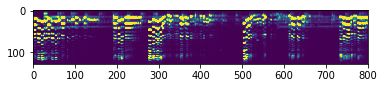

In [6]:
spec, genre = next(iter(data_loader))
print(f"spec shape: {spec.shape}")
plt.imshow(spec[0][0], vmin=0, vmax=0.5)


## 2. Defining the encoder and the decoder

Define as `nn.Module`s:
- the encoder
   - Input: waveform
   - Output: latent representation
- the decoder
   - Input: latent representation
   - Ouptput: waveform
- an encoder-decoder that chains them both for convenience

### Shapes
| Stage                  | Shape            | Meaning                      |
| ---------------------- | ---------------- | ---------------------------- |
| Input `spec`           | [5, 3, 128, 801] | (batch, channel, freq, time) |
| Output of `ResNet34Cut`| [5, 256, 8, 51]  | (batch, stack, freq2, time2) |
| Intput of LSTM         | [5, 2048, 51]    | (batch, freq3, time3)        |
| Output of LSTM         | [5, 2048]        | (batch, component)           |

### 2.1 Resnet utilities

Cut the resnet34 architecture to keep more detailed information (and not loose temporal dimension):

NB: the `forward` implementation is almost copy-pasted from the torchvision sources, from [here](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet34).

Also, define an inverse module for that architecture to be used in the decoder.

In [56]:
class ResNet34Cut(imgmodels.ResNet):
    def __init__(self, pretrained=True):
        resnet = imgmodels.resnet34(pretrained=pretrained)
        for k, v in resnet.__dict__.items():
            setattr(self, k, v)
        
        # self.fc = nn.Linear(256, 1000)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x

class InverseResNet34Cut(nn.Module):
    channels = [256, 128, 64, 64, 3]
    kernel_sizes = [(3, 3), (3, 3), (3, 3), (3, 3)]
    mid_kernel_size = (3, 3)
    num_mid_layers = [2, 1, 1, 0]

    def __init__(self):
        super().__init__()
        self.layer1 = self._make_layer(
            in_channels = self.channels[0],
            out_channels = self.channels[1],
            kernel_size = self.kernel_sizes[0],
            padding = (1, 2),
            num_mid_layers = self.num_mid_layers[0],
            mid_kernel_size = self.mid_kernel_size,
        )
        
        self.layer2 = self._make_layer(
            in_channels = self.channels[1], 
            out_channels = self.channels[2],
            kernel_size = self.kernel_sizes[1],
            num_mid_layers = self.num_mid_layers[1],
            mid_kernel_size = self.mid_kernel_size
        )
        
        self.layer3 = self._make_layer(
            in_channels = self.channels[2], 
            out_channels = self.channels[3],
            kernel_size = self.kernel_sizes[2],
            num_mid_layers =self.num_mid_layers[2],
            mid_kernel_size = self.mid_kernel_size
        )

        self.layer4 = self._make_layer(
            in_channels = self.channels[3],
            out_channels = self.channels[4],
            kernel_size = self.kernel_sizes[3],
            num_mid_layers = self.num_mid_layers[3],
            mid_kernel_size = self.mid_kernel_size,
            padding = (1, 0),
            output_padding = (1, 0)
        )
    
    def _make_transition_layer(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Tuple[int, int],
        padding: Tuple[int, int] = (1, 1),
        output_padding: Tuple[int, int] = (1, 1)
    ) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=(2, 2),
                padding=padding,
                output_padding=output_padding
            ),
            nn.BatchNorm2d(out_channels, momentum=0.01),
            nn.ReLU()
        )
    
    def _make_mid_layer(self, channels: int, kernel_size: int) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=kernel_size,
                padding=1
            ),
            nn.BatchNorm2d(channels, momentum=0.01),
            nn.ReLU()
        )
    
    def _make_layer(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Tuple[int, int],
        num_mid_layers: int,
        mid_kernel_size: Tuple[int, int],
        padding: Tuple[int, int] = (1, 1),
        output_padding: Tuple[int, int] = (1, 1),
    ) -> nn.Module:
        l = []
        l.append(self._make_transition_layer(
            in_channels, out_channels, kernel_size, padding, output_padding
        ))
        for _ in range(num_mid_layers):
            l.append(self._make_mid_layer(out_channels, mid_kernel_size))
        
        return nn.Sequential(*l)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = [5, 256, 8, 51]
        x = self.layer1(x)
        # x.shape = [5, 128, 16, 100]
        x = self.layer2(x)
        # x.shape = [5, 64, 32, 200]
        x = self.layer3(x)
        # x.shape = [5, 32, 32, 400]
        x = self.layer4(x)
        # x.shape = [5, 3, 128, 801]
        return x

In [57]:
# test shapes are coherent
resnet = ResNet34Cut()
inverse = InverseResNet34Cut()

x = torch.randn([1, 3, 128, 801])
print(f"x.shape = {x.shape}")
y = resnet(x)
print(f"y.shape = {y.shape}")
z = inverse(y)
print(f"z.shape = {z.shape}")

x.shape = torch.Size([1, 3, 128, 801])
y.shape = torch.Size([1, 256, 8, 51])
z.shape = torch.Size([1, 3, 128, 801])


### 2.2 Encoder and decoder

In [102]:
class Encoder(nn.Module):
    def __init__(
        self,
        lstm_input_size: int = 2048,
        hidden_size: int = 2048,
        num_lstm_layers: int = 1,
        output_size: int = 2048
    ):
        super(Encoder, self).__init__()

        self.resnet = ResNet34Cut(pretrained=True)
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            # no need to specify sequence length
        )
        self.h0 = nn.parameter.Parameter(torch.randn(hidden_size))
        self.c0 = nn.parameter.Parameter(torch.randn(hidden_size))

        self.fc = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        # x.shape = [5, 3, 128, 801]
        x = self.resnet(x)
        # # x.shape = [5, 256, 8, 51] 
        # x = x.view(5, -1, 51)
        # # x.shape = [5, 2048, 51]
        # x = x.swapaxes(1, 2)
        x = x.view(batch_size, -1, 51).swapaxes(1, 2)
        # x.shape = [5, 51, 2048]
        h0 = self.h0.repeat(batch_size, 1).unsqueeze(0)
        c0 = self.c0.repeat(batch_size, 1).unsqueeze(0)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        # x.shape = [5, 2048]
        x = self.fc(hn)
        # x.shape = [5, output_size]
        return x

class Decoder(nn.Module):
    def __init__(
        self,
        input_size=2048,
        lstm_input_size=2048,
        hidden_size=2048,
        sequence_length=51,
        num_lstm_layers=1
    ):
        super(Decoder, self).__init__()

        self.const_x = nn.parameter.Parameter(torch.randn(hidden_size))
        self.const_xr = self.const_x.repeat(1, sequence_length-1, 1)
        self.h0 = nn.parameter.Parameter(torch.randn(hidden_size))
        self.c0 = nn.parameter.Parameter(torch.randn(hidden_size))

        self.fc = nn.Linear(input_size, lstm_input_size)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            # no need to specify sequence length
        )
        self.reverse_resnet = InverseResNet34Cut()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        # x.shape = [5, input_size]
        x = self.fc(x)
        # x.shape = [5, lstm_input_size]

        fill = self.const_xr.repeat(batch_size, 1, 1)
        lstm_input = torch.cat([x, fill], 1)
        # x.shape = [5, lstm_input_size]
        h0 = self.h0.repeat(batch_size, 1).unsqueeze(0)
        c0 = self.c0.repeat(batch_size, 1).unsqueeze(0)
        x, (hn, cn) = self.lstm(lstm_input, (h0, c0))
        # # x.shape = [5, 51, 2048]
        # x = x.swapaxes(1, 2)
        # # x.shape = [5, 2048, 51]
        # x = x.view(5, 256, 8, 51)
        x = x.swapaxes(1, 2).view(batch_size, 256, 8, 51)
        
        # x.shape = [5, 256, 8, 51]
        x = self.reverse_resnet(x)

        # x.shape = [5, 3, 128, 801]
        return x


class EncoderDecoder(nn.Module):
    def __init__(
        self,
        lstm_input_size=2048,
        hidden_size=2048,
        sequence_length=51,
        num_lstm_layers=1
    ):
        super(EncoderDecoder, self).__init__()

        self.encoder = Encoder(
            lstm_input_size=lstm_input_size,
            hidden_size=hidden_size,
            sequence_length=sequence_length,
            num_lstm_layers=num_lstm_layers
        )
        self.decoder = Decoder(
            lstm_input_size=lstm_input_size,
            hidden_size=hidden_size,
            sequence_length=sequence_length,
            num_lstm_layers=num_lstm_layers
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [92]:
v = torch.tensor([1, 2, 3, 4, 5])
v = v.repeat(1, 9, 1)
# u = torch.tensor([2**i for i in range(10)]).reshape(2, 1, 5)
# torch.cat([u, v], 1)
v.repeat(3, 1, 1).shape


torch.Size([3, 9, 5])

In [103]:
# testing...

encoder = Encoder()
decoder = Decoder()

x = torch.randn([1, 3, 128, 801])
v = encoder(x)
y = decoder(v)
print(f"y.shape = {y.shape}")

y.shape = torch.Size([1, 3, 128, 801])
